# Madison crime example
This exercise focuses on working with [vector GIS data](https://docs.qgis.org/3.4/en/docs/gentle_gis_introduction/vector_data.html) in python. In this example, we'll use the python GIS stack to look at the spatial distribution of crime in Madison, WI. We'll mostly work with [`geopandas`](http://geopandas.org/), a high-level library that allows vector data and their attributes to be manipulated simultaneously in a `GeoDataFrame`. `geopandas` inherits the `DataFrame` class from `pandas`, which is in turn built on top of `numpy.` It wraps functionality in the `fiona`, `shapely` and `pyproj` libraries, which in turn wrap general C/C++ libraries that do the actual computations.

#### Datasets:
* City of Madison incident dataset, available from https://moto.data.socrata.com/dataset/City-of-Madison/dddr-t8pv (accessed 11/6/2019 for this example).
* Wisconsin Neighborhood boundaries (for Madison and Milwaukee), from Zillow: http://www.zillow.com/static/shp/ZillowNeighborhoods-WI.zip (accessed 11/7/2016 for this example)  

#### Operations:
* read and write shapefiles to/from `GeoDataFrames`
* creating a `GeoDataFrame` from scratch
* plotting shapefile contents
* vector operations (dissolve, dataset clipping based on spatial relationships, buffers)
* spatial joins
* coordinate transformations
* visualization and general data wrangling

#### References:
* [GeoPandas documentation](http://geopandas.org/index.html)
* Most vector operations (dissolve, buffer, intersection testing, clipping, etc.) are performed in-memory via `shapely` object methods.   
The [shapely manual](https://shapely.readthedocs.io/en/stable/manual.html) is a great resource for learning about these operations.
* The [GeoHackWeek tutorials](https://geohackweek.github.io/vector/) for more information on `geopandas` and working with geospatial vector data in the python

In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import pyproj
from shapely.geometry import Point, box
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
neighborhoods = 'data/gis/ZillowNeighborhoods-WI/ZillowNeighborhoods-WI.shp'
crimedata = 'data/pandas/msn_crime.csv'

plt.rcParams['figure.figsize'] = (11, 8.5)

### read in the neighborhood boundaries
* `geopandas.read_file` reads a shapefile, and returns a `GeoDataFrame` of the attribute information, with the feature geometries stored in a `geometry` column as `shapely Point, Linstring, or Polygon` objects. It also includes a `.crs` attribute that specifies the coordinate reference system (CRS) for the features.

In [3]:
nb = gp.read_file(neighborhoods)

# the dataset includes some other neighborhoods outside of Madison proper; 
# slice the dataframe to only include Madison neighborhoods
msn = nb[nb.CITY == 'Madison'].copy()

In [4]:
msn.crs

{'init': 'epsg:4269'}

In [5]:
msn.head()

,STATE,COUNTY,CITY,NAME,REGIONID,geometry
0,WI,Dane,Madison,Highlands Community,343536.0,"POLYGON ((-89.49236 43.08246, -89.49069 43.082..."
1,WI,Dane,Madison,Sheridan Triangle,343521.0,"POLYGON ((-89.36378 43.11511, -89.36490 43.115..."
2,WI,Dane,Madison,Woodland Hills,343538.0,"POLYGON ((-89.49503 43.07521, -89.49613 43.075..."
3,WI,Dane,Madison,Walnut Grove,343543.0,"POLYGON ((-89.50440 43.06796, -89.50449 43.067..."
9,WI,Dane,Madison,Whitetail Ridge,272303.0,"POLYGON ((-89.36316 43.14025, -89.36314 43.140..."


In [6]:
msn.index = msn.NAME
msn

,STATE,COUNTY,CITY,NAME,REGIONID,geometry
NAME,,,,,,
Highlands Community,WI,Dane,Madison,Highlands Community,343536.0,"POLYGON ((-89.49236 43.08246, -89.49069 43.082..."
Sheridan Triangle,WI,Dane,Madison,Sheridan Triangle,343521.0,"POLYGON ((-89.36378 43.11511, -89.36490 43.115..."
Woodland Hills,WI,Dane,Madison,Woodland Hills,343538.0,"POLYGON ((-89.49503 43.07521, -89.49613 43.075..."
Walnut Grove,WI,Dane,Madison,Walnut Grove,343543.0,"POLYGON ((-89.50440 43.06796, -89.50449 43.067..."
Whitetail Ridge,WI,Dane,Madison,Whitetail Ridge,272303.0,"POLYGON ((-89.36316 43.14025, -89.36314 43.140..."
...,...,...,...,...,...,...
Tenney-Lapham,WI,Dane,Madison,Tenney-Lapham,343530.0,"POLYGON ((-89.38300 43.08180, -89.38287 43.081..."
Eken Park,WI,Dane,Madison,Eken Park,272087.0,"POLYGON ((-89.33851 43.10724, -89.33880 43.107..."
Heritage Heights,WI,Dane,Madison,Heritage Heights,343527.0,"POLYGON ((-89.29931 43.08427, -89.29931 43.084..."


Shapely feature objects display in Notebooks as a drawing of the feature

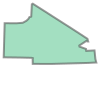

In [7]:
msn.geometry[0]

In [8]:
msn.geometry[0].__repr__()

'<shapely.geometry.polygon.Polygon object at 0x11d7b0860>'

### quick plot to show the neighborhoods

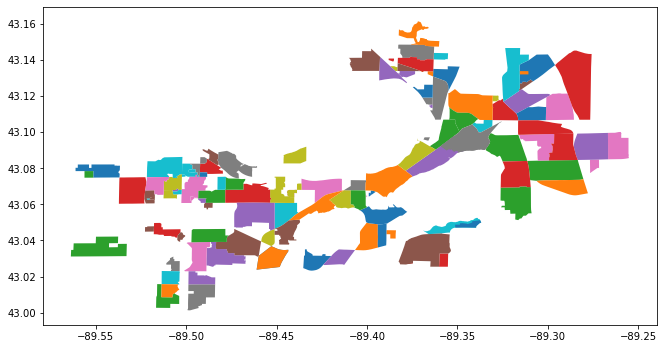

In [9]:
ax = msn.plot(column='NAME')

### get the bounding box encompassing all of the neighborhoods
* we'll need this later for cleaning the point data
* the easiest way to do this is to dissolve them into a `MultiPolygon`, which has a bounds attribute

In [10]:
help(msn.dissolve)

Help on method dissolve in module geopandas.geodataframe:

dissolve(by=None, aggfunc='first', as_index=True) method of geopandas.geodataframe.GeoDataFrame instance
    Dissolve geometries within `groupby` into single observation.
    This is accomplished by applying the `unary_union` method
    to all geometries within a groupself.
    
    Observations associated with each `groupby` group will be aggregated
    using the `aggfunc`.
    
    Parameters
    ----------
    by : string, default None
        Column whose values define groups to be dissolved
    aggfunc : function or string, default "first"
        Aggregation function for manipulation of data associated
        with each group. Passed to pandas `groupby.agg` method.
    as_index : boolean, default True
        If true, groupby columns become index of result.
    
    Returns
    -------
    GeoDataFrame



In [11]:
result = msn.dissolve(by='STATE')  # Note that we could dissolve the data categorically into multiple MultiPolygons
result

,geometry,COUNTY,CITY,NAME,REGIONID
STATE,,,,,
WI,"MULTIPOLYGON (((-89.45138 43.03811, -89.45295 ...",Dane,Madison,Highlands Community,343536.0


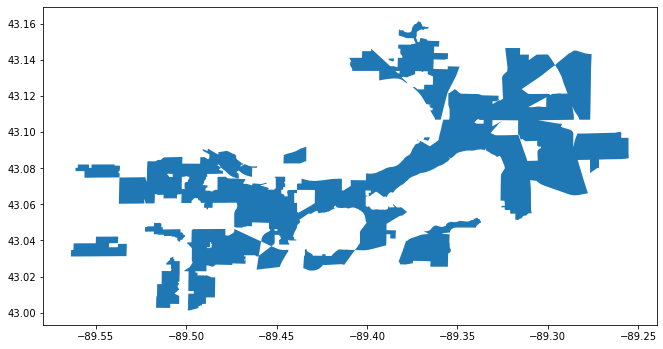

In [12]:
result = msn.dissolve(by='STATE')
result.plot()

In [13]:
msn_extent = result.bounds.values
msn_extent

array([[-89.56387304,  43.00134665, -89.25519045,  43.16126544]])

In [14]:
x1, y1, x2, y2 = msn_extent[0]

### Read indicident data into `pandas DataFrame`

In [15]:
df = pd.read_csv(crimedata)

In [16]:
df.head()

,incident_datetime,incident_type_primary,incident_description,address_1,latitude,longitude,parent_incident_type
0,01/06/2017 02:15:28 PM,Accident Private Property,Accident Private Property,1 Block S PARK ST,42.85960,-89.532500,Traffic
1,12/30/2016 04:39:10 PM,Check Person,Check Person,200 Block STATE ST,43.07475,-89.388695,Community Policing
2,12/31/2016 06:52:52 AM,Check Person,Check Person,100 Block E MIFFLIN ST,43.07640,-89.383700,Community Policing
3,11/16/2017 08:27:00 AM,Theft,Theft,3800 Block NAKOMA RD,43.04600,-89.442500,Theft
4,12/29/2017 09:58:32 AM,Theft,Theft,7300 Block WEST TOWNE WAY,43.05500,-89.511000,Theft


Casting the `incident_datetime` column to a pandas datetime series takes awhile because of the non-standard format of `%m/%d/%Y` instead of `YYYY/MM/DD`, which means pandas has to do extra work to determine the format for each of the 833k+ dates.

In [17]:
%%time
df.index = pd.to_datetime(df.incident_datetime)

CPU times: user 1min 24s, sys: 36.2 ms, total: 1min 24s
Wall time: 1min 24s


If we give the format to pandas instead, we speed this up almost 30x

In [18]:
%%time
df.index = pd.to_datetime(df.incident_datetime, format='%m/%d/%Y %I:%M:%S %p')

CPU times: user 2.82 s, sys: 10.2 ms, total: 2.83 s
Wall time: 2.82 s


In [19]:
df.head()

,incident_datetime,incident_type_primary,incident_description,address_1,latitude,longitude,parent_incident_type
incident_datetime,,,,,,,
2017-01-06 14:15:28,01/06/2017 02:15:28 PM,Accident Private Property,Accident Private Property,1 Block S PARK ST,42.85960,-89.532500,Traffic
2016-12-30 16:39:10,12/30/2016 04:39:10 PM,Check Person,Check Person,200 Block STATE ST,43.07475,-89.388695,Community Policing
2016-12-31 06:52:52,12/31/2016 06:52:52 AM,Check Person,Check Person,100 Block E MIFFLIN ST,43.07640,-89.383700,Community Policing
2017-11-16 08:27:00,11/16/2017 08:27:00 AM,Theft,Theft,3800 Block NAKOMA RD,43.04600,-89.442500,Theft
2017-12-29 09:58:32,12/29/2017 09:58:32 AM,Theft,Theft,7300 Block WEST TOWNE WAY,43.05500,-89.511000,Theft


### Count number of incidents by date, and plot

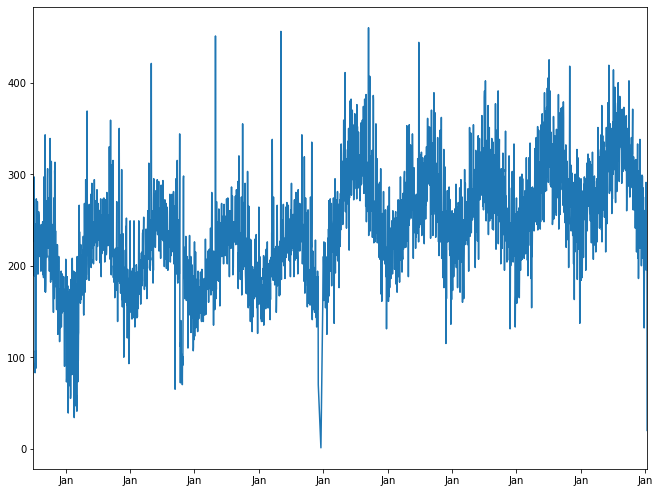

In [20]:
import matplotlib.dates as dates
ax = df.groupby(df.index.date).count().incident_datetime.plot()
ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))


### plot number of incidents in each month

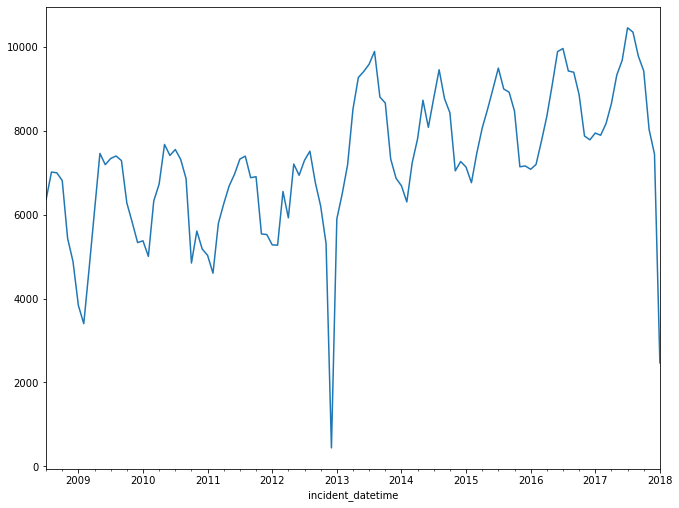

In [21]:
monthly_incidents = df.resample('M').count().incident_datetime
monthly_incidents.plot()

### Average number of incidents in each month of the year

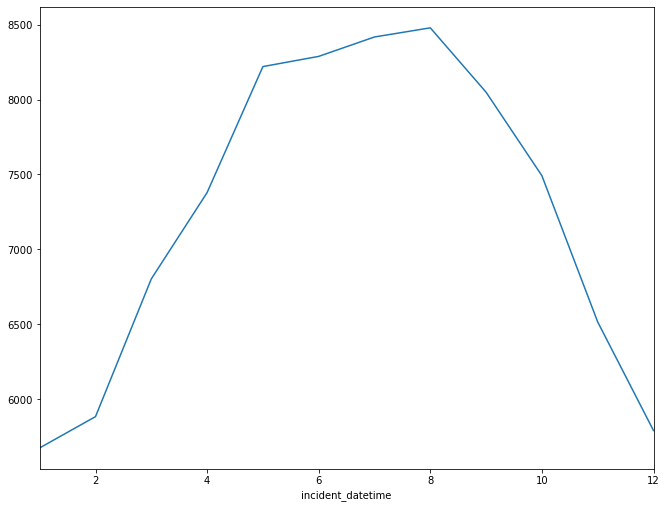

In [22]:
monthly_incidents.groupby(monthly_incidents.index.month).mean().plot()

### list the all of the incident types in that dataset

In [23]:
df.incident_type_primary.unique()

array(['Accident Private Property', 'Check Person', 'Theft',
       'Traffic Stop', 'Check Property', 'Civil Dispute', '-Theft',
       'Information', 'Traffic Complaint/Investigation', 'Disturbance',
       'Domestic Disturbance', 'Neighbor Trouble',
       'Accident Property Damage', 'Trespass', 'Towed Vehicle',
       'Accident Hit and Run', 'Alarm', 'Battery', 'Theft from Auto',
       'Fraud', 'Check Parking Postings', 'Liquor Law/Bar Check',
       'Suspicious Person', 'Stolen Auto', 'Suspicious Vehicle',
       'Damage to Property', 'Fraud/Identity Theft', 'Stolen Bicycle',
       'Accident w/Injuries', 'Noise Complaint', 'Burglary Residential',
       'Traffic Incident', 'Injured Person', 'Preserve the Peace',
       '-Road Rage', '-Drug Incident', '-Fraud', 'Road Rage',
       'Fight Call', 'Foot Patrol', 'Missing Adult', 'Forgery',
       'Intoxicated Person', 'OMVWI Arrest/Intoxicated Driver',
       'Liquor Law Violation', '-Stolen Bike', '-Disturbance Call',
       'Extort

### Plot incidents with neighborhoods
* overplotting of points (with `alpha=0.1` to set a 90% transparency) in dense areas prevents us from seeing how much crime they actually have

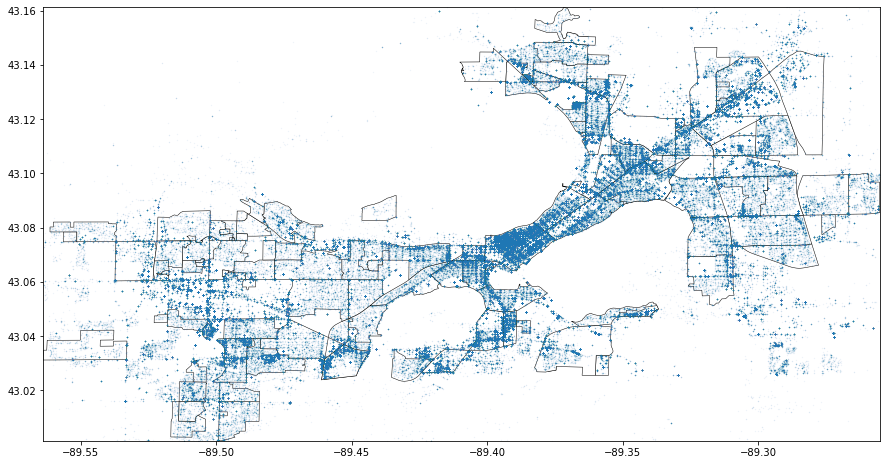

In [24]:
fig, ax = plt.subplots(figsize=(15, 10))
# this is how you'd have to do it without GeoPandas
#collection = PatchCollection([PolygonPatch(p) for p in msn.geometry], facecolor='w')
#ax.add_collection(collection)
msn.plot(ax=ax, fc='w', ec='k', lw=0.5)
ax.set_ylim(y1, y2)
ax.set_xlim(x1, x2)
ax.scatter(df.longitude, df.latitude, s=0.1, alpha=0.1)
ax.set_aspect(1)

### Get the number of incidents occuring within each neighborhood, via a spatial join
* to do this, we need to test each point against each neighborhood
* `geopandas` speeds this up under the hood using the `rtree` package, which creates a spatial index with an [rtree structure](https://en.wikipedia.org/wiki/R-tree) to speed lookups

In [25]:
print('{:,} intersections'.format(len(df) * len(msn)))

103,337,880 intersections


#### create a GeoDataFrame from the regular dataframe of the incidents

In [26]:
df['geometry'] = [Point(x, y) for x, y in zip(df.longitude, df.latitude)]
df = gp.GeoDataFrame(df, crs={'init' :'epsg:4269'})

#### do the spatial join

In [27]:
%%time
result = gp.sjoin(df, msn, how='inner', op='within')

CPU times: user 47.2 s, sys: 440 ms, total: 47.7 s
Wall time: 47.7 s


In [28]:
result.head()

,incident_datetime,incident_type_primary,incident_description,address_1,latitude,longitude,parent_incident_type,geometry,index_right,STATE,COUNTY,CITY,NAME,REGIONID
2016-12-30 16:39:10,12/30/2016 04:39:10 PM,Check Person,Check Person,200 Block STATE ST,43.074750,-89.388695,Community Policing,POINT (-89.38869 43.07475),Capitol,WI,Dane,Madison,Capitol,272060.0
2016-12-31 06:52:52,12/31/2016 06:52:52 AM,Check Person,Check Person,100 Block E MIFFLIN ST,43.076400,-89.383700,Community Policing,POINT (-89.38370 43.07640),Capitol,WI,Dane,Madison,Capitol,272060.0
2017-01-11 22:41:28,01/11/2017 10:41:28 PM,Check Property,Check Property,600 Block W MAIN ST,43.066391,-89.392633,Community Policing,POINT (-89.39263 43.06639),Capitol,WI,Dane,Madison,Capitol,272060.0
2017-12-30 00:34:14,12/30/2017 12:34:14 AM,Trespass,Trespass,100 Block KING ST,43.074900,-89.380900,Property Crime,POINT (-89.38090 43.07490),Capitol,WI,Dane,Madison,Capitol,272060.0
2017-12-14 08:06:00,12/14/2017 08:06:00 AM,Trespass,Trespass,700 Block STATE ST,43.074600,-89.397800,Property Crime,POINT (-89.39780 43.07460),Capitol,WI,Dane,Madison,Capitol,272060.0


In [29]:
result.rename(columns={'NAME': 'neighborhood'}, inplace=True)

### count the number of incidents in each neighborhood  
* assign this to a new column in the neighborhoods dataframe

In [30]:
counts = result.groupby('neighborhood').count()
counts.head()

,incident_datetime,incident_type_primary,incident_description,address_1,latitude,longitude,parent_incident_type,geometry,index_right,STATE,COUNTY,CITY,REGIONID
neighborhood,,,,,,,,,,,,,
Allied Community,15243,15243,15243,15243,15243,15243,15243,15243,15243,15243,15243,15243,15243
Appalachian Ridge,60,60,60,60,60,60,60,60,60,60,60,60,60
Arbor Hills,2328,2328,2328,2328,2328,2328,2328,2328,2328,2328,2328,2328,2328
Bay Creek,12673,12673,12673,12673,12673,12673,12673,12673,12673,12673,12673,12673,12673
Bayview,562,562,562,562,562,562,562,562,562,562,562,562,562


In [31]:
msn['n_incidents'] = counts['CITY']
msn.head()

,STATE,COUNTY,CITY,NAME,REGIONID,geometry,n_incidents
NAME,,,,,,,
Highlands Community,WI,Dane,Madison,Highlands Community,343536.0,"POLYGON ((-89.49236 43.08246, -89.49069 43.082...",159
Sheridan Triangle,WI,Dane,Madison,Sheridan Triangle,343521.0,"POLYGON ((-89.36378 43.11511, -89.36490 43.115...",495
Woodland Hills,WI,Dane,Madison,Woodland Hills,343538.0,"POLYGON ((-89.49503 43.07521, -89.49613 43.075...",984
Walnut Grove,WI,Dane,Madison,Walnut Grove,343543.0,"POLYGON ((-89.50440 43.06796, -89.50449 43.067...",1127
Whitetail Ridge,WI,Dane,Madison,Whitetail Ridge,272303.0,"POLYGON ((-89.36316 43.14025, -89.36314 43.140...",573


In [32]:
msn.sort_values('n_incidents', ascending=False).head(10)

,STATE,COUNTY,CITY,NAME,REGIONID,geometry,n_incidents
NAME,,,,,,,
Capitol,WI,Dane,Madison,Capitol,272060.0,"POLYGON ((-89.40096 43.06766, -89.40095 43.068...",131002
South Campus,WI,Dane,Madison,South Campus,272252.0,"POLYGON ((-89.41278 43.06781, -89.41222 43.068...",34969
Marquette,WI,Dane,Madison,Marquette,343528.0,"POLYGON ((-89.35112 43.09717, -89.35145 43.096...",22178
Schenk-Atwood-Starkweather-Yahar,WI,Dane,Madison,Schenk-Atwood-Starkweather-Yahar,343577.0,"POLYGON ((-89.33120 43.09993, -89.33145 43.099...",20446
Greenbush,WI,Dane,Madison,Greenbush,343557.0,"POLYGON ((-89.40902 43.05997, -89.40900 43.062...",19365
Tenney-Lapham,WI,Dane,Madison,Tenney-Lapham,343530.0,"POLYGON ((-89.38300 43.08180, -89.38287 43.081...",19029
Burr Oaks,WI,Dane,Madison,Burr Oaks,272056.0,"POLYGON ((-89.39404 43.04757, -89.39404 43.047...",18886
Allied Community,WI,Dane,Madison,Allied Community,343582.0,"POLYGON ((-89.44618 43.03473, -89.44572 43.034...",15243
Dunn's Marsh,WI,Dane,Madison,Dunn's Marsh,272082.0,"POLYGON ((-89.44618 43.03473, -89.44572 43.034...",15243


### Plot number of incidents by neighborhood
* clip the colorscale so downtown doesn't wash out other neighborhoods
* the `legend_kwds` passes arguments to `matplotlib.pyplot.colorbar()`, to adjust the appearance of the colorbar

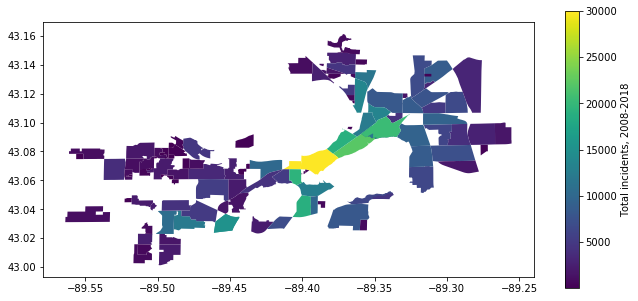

In [33]:
ax = msn.plot('n_incidents', legend=True, vmax=30000, 
              legend_kwds={'shrink': 0.6, 
                           'label': 'Total incidents, {}-{}'.format(df.index.year.min(),
                                                                    df.index.year.max())})

## What if we want more detail? Is the crime pretty evenly distributed throughout the Capitol neighborhood, or are there one or more hot spots?
* To get at this, we will make a 2D (spatial) histogram of the incident data. 
* To investgate any hot spots, it'll be easier to work in projected coordinates (meters), so we'll project the data first.  
* Before doing anything, we'll drop any points that are outside of the bounding box for Madison. Invalid points (e.g. 0, 0) will mess up the histogram.

#### Make a shapely polygon of the bounding box for Madison
* clip the point data by testing whether each point is inside the box
* this could easily be done in numpy as well. How would we set that up?

In [34]:
msn_bbox = box(x1, y1, x2, y2)  # make the polygon using the `box()` constructor
within = [g.within(msn_bbox) for g in df.geometry]  # test the points
df = df.loc[within].copy()  # slice the dataframe into a copy (discarding the invalid rows)

### Two ways of doing coordinate transformations (reprojections)
* `GeoDataFrame.to_crs()` method
    * projections can be specified as 
        [CRS mappings](https://fiona.readthedocs.io/en/latest/fiona.html#module-fiona.crs), 
        [proj-strings](https://proj.org/usage/quickstart.html), or 
        [epsg codes](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset)
    * while convenient, this method can be slow, because each it requires method calls to each shapely object in the `geometry`, with the python interpreter (i.e. not at the C++ level). This [may change](https://matthewrocklin.com/blog/work/2017/09/21/accelerating-geopandas-1) soon in upcoming releases of geopandas with the [integration](https://github.com/geopandas/geopandas/issues/1155) of [pygeos](https://github.com/pygeos/pygeos).
* For a large data set of points (described by numpy arrays of x and y values), `pyproj` is faster

#### reproject the incidents DataFrame to Wisconsin Transverse Mercator (EPSG 3070)
* first create a transform instance
    * projections are specified as PROJ strings
    * Note: as of pyproj 2, `always_xy=True` needs to be specified when using x, y (long, lat) ordering for geographic coordinate systems that are not defined in that order (for example, `epsg:4269`). More about it [here](https://pyproj4.github.io/pyproj/dev/api/transformer.html). 

In [35]:
%%time

transformer = pyproj.Transformer.from_crs('epsg:4269', 'epsg:3070', always_xy=True)

# do the transform
x_3070, y_3070 = transformer.transform(df.longitude.values, df.latitude.values)
df['x'] = x_3070
df['y'] = y_3070

# make a new set of points for the geometry column with the transformed values
df['geometry'] = [Point(x, y) for x, y in zip(x_3070, y_3070)]

CPU times: user 7.61 s, sys: 102 ms, total: 7.71 s
Wall time: 7.76 s


#### since we set the geometry manually with a new CRS, we also need to update the crs attribute
(otherwise, `geopandas` won't know that the CRS changed)

In [36]:
df.crs = {'init': 'epsg:3070'}

#### example of the `to_crs` method to reproject the neighborhoods dataframe

In [37]:
msn.to_crs(epsg=3070)

,STATE,COUNTY,CITY,NAME,REGIONID,geometry,n_incidents
NAME,,,,,,,
Highlands Community,WI,Dane,Madison,Highlands Community,343536.0,"POLYGON ((561321.618 290097.200, 561457.809 29...",159
Sheridan Triangle,WI,Dane,Madison,Sheridan Triangle,343521.0,"POLYGON ((571760.086 293794.370, 571669.552 29...",495
Woodland Hills,WI,Dane,Madison,Woodland Hills,343538.0,"POLYGON ((561109.079 289290.255, 561019.424 28...",984
Walnut Grove,WI,Dane,Madison,Walnut Grove,343543.0,"POLYGON ((560351.173 288480.443, 560343.628 28...",1127
Whitetail Ridge,WI,Dane,Madison,Whitetail Ridge,272303.0,"POLYGON ((571789.598 296585.985, 571790.839 29...",573
...,...,...,...,...,...,...,...
Tenney-Lapham,WI,Dane,Madison,Tenney-Lapham,343530.0,"POLYGON ((570223.876 290083.223, 570234.478 29...",19029
Eken Park,WI,Dane,Madison,Eken Park,272087.0,"POLYGON ((573823.563 292935.980, 573799.956 29...",13486
Heritage Heights,WI,Dane,Madison,Heritage Heights,343527.0,"POLYGON ((577033.763 290411.331, 577033.729 29...",4009


### Make the histogram
Note: `pyplot.hist2d` returns 4 items (numpy arrays of the counts, x and y values, and a `quadmesh` instance).   
We can store those in their own variables for future access using parallel assignment:

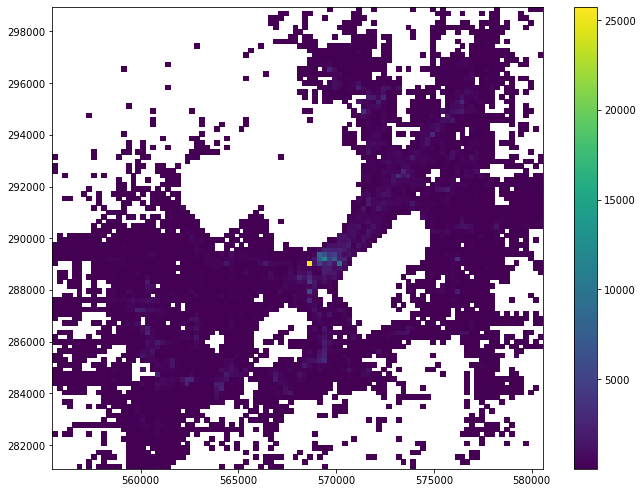

In [38]:
h2d_array, h2d_array_x, h2d_array_y, qm = plt.hist2d(x_3070, y_3070,
                                                     bins=(100, 100), cmin=1)
plt.colorbar(qm)

### what is going on with the yellow point above (with ~25,000 incidents?)
`np.argmax` can give us the location of a maximum value, but unfortunately only returns the one-dimensional position (of the unraveled array). Note that we have to use `np.nanargmax` because our array has nan values.

Once we have the row, column location, we can 
* covert it to an x, y, 
* make a small buffer around it, and then 
* get the incidents that occured within this buffer

In [39]:
np.nanargmax(h2d_array)

5244

#### convert the 1D index to a row, column location

In [40]:
i, j = np.unravel_index(np.nanargmax(h2d_array, axis=None), h2d_array.shape)
i, j 

(52, 44)

#### then convert this to an x, y location; check the location

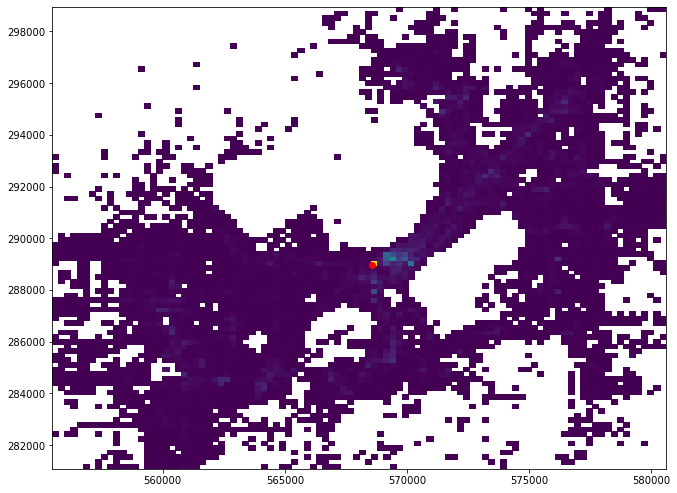

In [41]:
x = h2d_array_x[i]
y = h2d_array_y[j]

h2d_array, h2d_array_x, h2d_array_y, qm = plt.hist2d(df.x.values, df.y.values,
                                                     bins=(100, 100), cmin=1)
plt.scatter(x, y, color='r')

### Make a small buffer similar in size to the histogram bin spacing

In [42]:
# get the bin spacing
dx = np.diff(h2d_array_x)[0]
dy = np.diff(h2d_array_y)[0]
dx, dy

(251.19884556124453, 178.75235174200498)

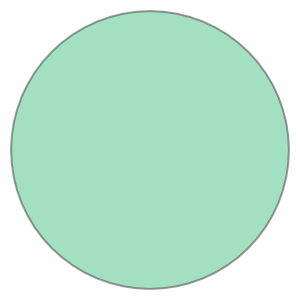

In [43]:
buff = Point(x, y).buffer(250)
buff

### Cull the incidents DataFrame to the points within the buffer

In [44]:
within = [g.within(buff) for g in df.geometry]
hotspot = df.loc[within].copy()

In [45]:
hotspot

,incident_datetime,incident_type_primary,incident_description,address_1,latitude,longitude,parent_incident_type,geometry,x,y
incident_datetime,,,,,,,,,,
2017-01-04 10:56:05,01/04/2017 10:56:05 AM,Traffic Stop,Traffic Stop,-0 USH 151 SB,43.073052,-89.40123,Traffic,POINT (568746.943 289101.071),568746.942726,289101.070898
2017-12-14 21:07:09,12/14/2017 09:07:09 PM,Theft,Theft,300 Block N BROOKS ST,43.072400,-89.40290,Theft,POINT (568611.516 289027.731),568611.516005,289027.730633
2016-12-16 18:18:45,12/16/2016 06:18:45 PM,Traffic Stop,Traffic Stop,-0 USH 12 EB,43.073052,-89.40123,Traffic,POINT (568746.943 289101.071),568746.942726,289101.070898
2016-12-16 18:35:37,12/16/2016 06:35:37 PM,Accident Property Damage,Accident Property Damage,2600 Block USH 12 WB,43.073052,-89.40123,Traffic,POINT (568746.943 289101.071),568746.942726,289101.070898
2017-01-03 23:01:53,01/03/2017 11:01:53 PM,Check Property,Check Property,EAST TRANSFER POINT,43.073052,-89.40123,Community Policing,POINT (568746.943 289101.071),568746.942726,289101.070898
...,...,...,...,...,...,...,...,...,...,...
2011-07-20 11:19:17,07/20/2011 11:19:17 AM,-Domestic/Family Trouble,Domestic/Family Trouble,7100 Block TREE LA,43.073052,-89.40123,Family Offense,POINT (568746.943 289101.071),568746.942726,289101.070898
2011-07-20 13:21:13,07/20/2011 01:21:13 PM,-Residential Burglary,Residential Burglary,6800 Block EAST PA,43.073052,-89.40123,Breaking & Entering,POINT (568746.943 289101.071),568746.942726,289101.070898
2011-07-20 14:00:17,07/20/2011 02:00:17 PM,-Suspicious Vehicle,Suspicious Vehicle,1200 Block MC KENNA BLVD,43.073052,-89.40123,Community Policing,POINT (568746.943 289101.071),568746.942726,289101.070898


#### It looks like most of the incidents near the hot spot have the same x, y location suggesting they weren't geolocated property
The first point in the hotspot dataframe is one of these. Let's drop all of these points from the incident dataframe.

In [46]:
isvalid = df.geometry != hotspot.geometry[0]

In [47]:
df = df.loc[isvalid].copy()

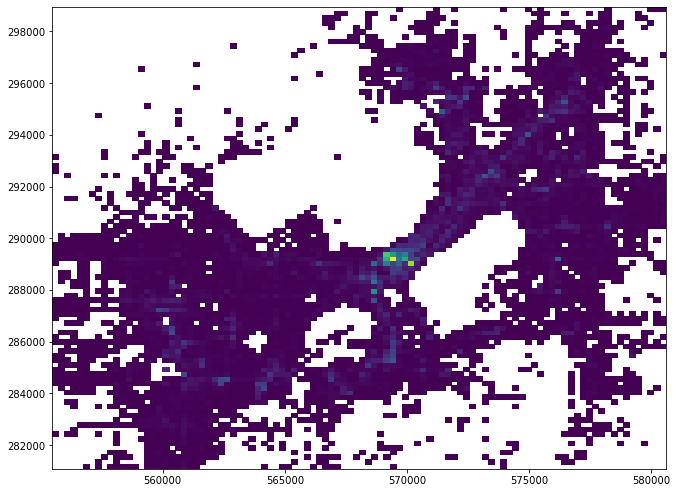

In [48]:
h2d_array, h2d_array_x, h2d_array_y, qm = plt.hist2d(df.x.values, df.y.values,
                                                     bins=(100, 100), cmin=1)

### this looks more promising. Let's repeat the analysis above.
That is, we'll get the location of the pixel in the 2D histogram with the most incidents, make a buffer (circle polygon) that is roughly the size of that pixel, and then subset the crime dataframe to the incidents that occurred within that buffer.

In [49]:
i, j = np.unravel_index(np.nanargmax(h2d_array, axis=None), h2d_array.shape)
x = h2d_array_x[i]
y = h2d_array_y[j]
buff = Point(x, y).buffer(250)
within = [g.within(buff) for g in df.geometry]
hotspot = df.loc[within].copy()

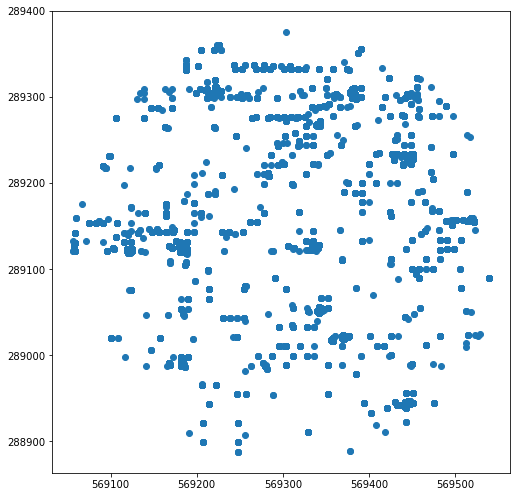

In [50]:
hotspot.plot()

#### addresses with the most incidents

In [51]:
hotspot.address_1.value_counts()

500 Block STATE ST                     5553
600 Block STATE ST                     2215
400 Block W GILMAN ST                  1785
400 Block N FRANCES ST                 1708
400 Block W GORHAM ST                  1546
                                       ... 
500 Block W JOHNAON ST                    1
400 BLOCK W GORHAM & N BROOM ST           1
500 BLOCK W JOHNSON ST & N BROOM ST       1
400 Block HAWTHORN                        1
STATE STREET                              1
Name: address_1, Length: 300, dtype: int64

In [52]:
hotspot.loc[hotspot.address_1 == '500 Block STATE ST'].head()

,incident_datetime,incident_type_primary,incident_description,address_1,latitude,longitude,parent_incident_type,geometry,x,y
incident_datetime,,,,,,,,,,
2017-11-04 00:08:46,11/04/2017 12:08:46 AM,Liquor Law/Bar Check,Liquor Law/Bar Check,500 Block STATE ST,43.074600,-89.394600,Liquor,POINT (569285.480 289276.884),569285.480019,289276.883719
2016-12-21 04:35:04,12/21/2016 04:35:04 AM,Alarm,Alarm,500 Block STATE ST,43.075100,-89.394700,Alarm,POINT (569276.938 289332.350),569276.938390,289332.350067
2011-05-01 19:20:41,05/01/2011 07:20:41 PM,-Fraud,Fraud,500 Block STATE ST,43.074844,-89.393406,Theft,POINT (569382.488 289304.649),569382.487861,289304.648807
2017-11-03 00:28:21,11/03/2017 12:28:21 AM,Disturbance,Disturbance,500 Block STATE ST,43.075100,-89.393700,Disorder,POINT (569358.348 289332.938),569358.347716,289332.937949
2017-11-03 02:17:38,11/03/2017 02:17:38 AM,Alarm,Alarm,500 Block STATE ST,43.074600,-89.394400,Alarm,POINT (569301.762 289277.001),569301.762017,289277.001237


In [53]:
hotspot.loc[hotspot.address_1 == '500 Block STATE ST', 'incident_description'].value_counts().head(20)

Check Person                             1185
Disturbance Call                          562
Disturbance                               448
Check Property                            409
Theft                                     347
Liquor Law Violation                      235
Noise Complaint                           188
Information                               187
Alarm                                     182
Liquor Law/Bar Check                      178
Assist Citizen                            160
PC Conveyance/Commitment (Chapter 51)     149
Foot Patrol                               132
Battery                                   122
Suspicious Person                         104
Trespass                                   90
Trespassing Complaint                      86
Fight Call                                 77
Adult Arrested Person                      68
Unwanted Person                            66
Name: incident_description, dtype: int64

In [54]:
hotspot.loc[hotspot.address_1 == '500 Block STATE ST', 'parent_incident_type'].value_counts()

Community Policing      2175
Disorder                1375
Liquor                   640
Theft                    446
Property Crime           274
Alarm                    182
Assault                  136
Other                     68
Drugs                     57
Family Offense            34
Traffic                   33
Quality of Life           31
Missing Person            28
Breaking & Entering       27
Proactive Policing        16
Weapons Offense            8
Robbery                    8
Other Sexual Offense       6
Theft of Vehicle           5
Emergency                  2
Sexual Offense             1
Theft from Vehicle         1
Name: parent_incident_type, dtype: int64

## Looking at this data on a map
In-notebook, we could do it 
* using the [`folium`](https://github.com/python-visualization/folium) or   [`ipyleaflet`](https://github.com/jupyter-widgets/ipyleaflet) packages  
* geopandas as has some options for [including base layers](http://geopandas.org/gallery/plotting_basemap_background.html)

In lieu of those options, we can also simply dump the GeoDataFrame out to a shapefile for viewing in a GIS GUI

In [55]:
hotspot.to_file('data/gis/downtown_crime.shp')

### let's also save the incident dataframe to a csv
drop the geometry column since it's not very useful as text

In [56]:
df.drop('geometry', axis=1).to_csv('data/gis/msn_crime_valid_points.csv', index=False)